# Import libraries

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import world_bank_data as wb
from kaleido.scopes.plotly import PlotlyScope

# Load and preprocess data:

In [2]:
CO2_EMISSION_DATA = "EN.ATM.CO2E.KT"
COUNTRY_POPULATION_SIZE_DATA = "SP.POP.TOTL"
POVERTY_HEADCOUNT_RATIO_DATA = "SI.POV.DDAY"
COUNTRY_LAND_AREA_DATA = "AG.LND.TOTL.K2"
COUNTRY_GDP_DATA = "NY.GDP.MKTP.CD"

## CO2 emissions data:

In [3]:
co2_emissions_df = (
    wb.get_series(CO2_EMISSION_DATA, simplify_index=True)
    .reset_index()
    .rename(columns={CO2_EMISSION_DATA: "co2 emissions"})
)

In [4]:
co2_emissions_df.head()

,Country,Year,co2 emissions
0,Arab World,1960,56005.299798
1,Arab World,1961,62578.605590
2,Arab World,1962,70562.050726
3,Arab World,1963,85085.751513
4,Arab World,1964,99693.913771


## Country population data:

In [5]:
# year 2019 has the most recent non-missing data
country_population_df = (
    wb.get_series(COUNTRY_POPULATION_SIZE_DATA, simplify_index=True, date="2019")
    .reset_index()
    .rename(columns={COUNTRY_POPULATION_SIZE_DATA: "population size"})
)

In [6]:
country_population_df.head()

,Country,population size
0,Arab World,4.278703e+08
1,Caribbean small states,7.401381e+06
2,Central Europe and the Baltics,1.023786e+08
3,Early-demographic dividend,3.290291e+09
4,East Asia & Pacific,2.340628e+09


## Country poverty percentage data:

In [7]:
poverty_percentages_df = (
    wb.get_series(POVERTY_HEADCOUNT_RATIO_DATA, simplify_index=True)
    .reset_index()
    .rename(columns={POVERTY_HEADCOUNT_RATIO_DATA: "poverty percentage"})
)

In [8]:
poverty_percentages_df.head()

,Country,Year,poverty percentage
0,Arab World,1960,NaN
1,Arab World,1961,NaN
2,Arab World,1962,NaN
3,Arab World,1963,NaN
4,Arab World,1964,NaN


## Country land area data:

In [9]:
# year 2017 has the most recent non-missing data
country_land_area_df = (
    wb.get_series(COUNTRY_LAND_AREA_DATA, simplify_index=True, date="2017")
    .reset_index()
    .rename(columns={COUNTRY_LAND_AREA_DATA: "land area"})
)

In [10]:
country_land_area_df.head()

,Country,land area
0,Arab World,1.123265e+07
1,Caribbean small states,4.048500e+05
2,Central Europe and the Baltics,1.105054e+06
3,Early-demographic dividend,3.310775e+07
4,East Asia & Pacific,2.439675e+07


## Country GDP data:

In [11]:
country_gdp_df = (
    wb.get_series(COUNTRY_GDP_DATA, simplify_index=True)
    .reset_index()
    .rename(columns={COUNTRY_GDP_DATA: "GDP"})
)

In [12]:
country_gdp_df.head()

,Country,Year,GDP
0,Arab World,1960,NaN
1,Arab World,1961,NaN
2,Arab World,1962,NaN
3,Arab World,1963,NaN
4,Arab World,1964,NaN


## Country income group data:

In [13]:
countries_df = wb.get_countries().reset_index()

In [14]:
countries_df.head()

,id,iso2Code,name,region,adminregion,incomeLevel,lendingType,capitalCity,longitude,latitude
0,ABW,AW,Aruba,Latin America & Caribbean,,High income,Not classified,Oranjestad,-70.0167,12.51670
1,AFG,AF,Afghanistan,South Asia,South Asia,Low income,IDA,Kabul,69.1761,34.52280
2,AFR,A9,Africa,Aggregates,,Aggregates,Aggregates,,NaN,NaN
3,AGO,AO,Angola,Sub-Saharan Africa,Sub-Saharan Africa (excluding high income),Lower middle income,IBRD,Luanda,13.2420,-8.81155
4,ALB,AL,Albania,Europe & Central Asia,Europe & Central Asia (excluding high income),Upper middle income,IBRD,Tirane,19.8172,41.33170


## Create aggregated data:

In [15]:
co2_emissions_agg_df = (
    co2_emissions_df.groupby(by="Country")
    .agg({"co2 emissions": "sum"})
    .reset_index()
    .sort_values(by="co2 emissions", ascending=False)
)

In [16]:
co2_emissions_agg_df.head()

,Country,co2 emissions
99,High income,6.359376e+08
182,OECD members,6.173915e+08
104,IDA & IBRD total,6.132433e+08
195,Post-demographic dividend,5.998324e+08
103,IBRD only,5.892744e+08


## Merge data into two data frames:

### Merge not-time based statistics:

In [17]:
columns_to_drop = [
    "id",
    "iso2Code",
    "name",
    "adminregion",
    "lendingType",
    "capitalCity",
    "longitude",
    "latitude",
]

In [18]:
overall_stats_df = (
    co2_emissions_agg_df.merge(right=country_land_area_df, on="Country")
    .merge(right=country_population_df, on="Country")
    .merge(right=countries_df, left_on="Country", right_on="name")
    .drop(columns=columns_to_drop)
    .sort_values(by="co2 emissions", ascending=False)
)

In [19]:
overall_stats_df.head()

,Country,co2 emissions,land area,population size,region,incomeLevel
0,High income,6.359376e+08,3.537757e+07,1.235853e+09,Aggregates,Aggregates
1,OECD members,6.173915e+08,3.558598e+07,1.359964e+09,Aggregates,Aggregates
2,IDA & IBRD total,6.132433e+08,9.334034e+07,6.486935e+09,Aggregates,Aggregates
3,Post-demographic dividend,5.998324e+08,3.147367e+07,1.112914e+09,Aggregates,Aggregates
4,IBRD only,5.892744e+08,7.096526e+07,4.816236e+09,Aggregates,Aggregates


### Merge time-based data frames:

In [20]:
time_series_df = (
    co2_emissions_df.merge(right=country_gdp_df, on=["Country", "Year"])
    .merge(right=poverty_percentages_df, on=["Country", "Year"])
    .sort_values(by="Year")
)

In [21]:
time_series_df.head()

,Country,Year,co2 emissions,GDP,poverty percentage
0,Arab World,1960,56005.299798,NaN,NaN
3904,Belarus,1960,NaN,NaN,NaN
3965,Belgium,1960,91000.272000,1.165872e+10,NaN
10370,Malta,1960,341.031000,NaN,NaN
4026,Belize,1960,44.004000,2.807189e+07,NaN


## Convert `dtyps`:

### `overall_stats_df`:

In [22]:
overall_stats_df.dtypes

Country             object
co2 emissions      float64
land area          float64
population size    float64
region              object
incomeLevel         object
dtype: object

### `time_series_df`:

In [23]:
time_series_df.dtypes

Country                object
Year                   object
co2 emissions         float64
GDP                   float64
poverty percentage    float64
dtype: object

In [24]:
time_series_df = time_series_df.astype({"Year": "int"})

In [25]:
time_series_df.dtypes

Country                object
Year                    int64
co2 emissions         float64
GDP                   float64
poverty percentage    float64
dtype: object

## Drop non-country rows

In [26]:
non_countries = countries_df.loc[lambda x: x["region"] == "Aggregates"]["name"].values

In [27]:
non_countries = np.append(non_countries, "Latin America & Caribbean")
non_countries = np.append(non_countries, "Sub-Saharan Africa")

### `overall_stats_df`:

In [28]:
overall_stats_df.shape

(262, 6)

In [29]:
overall_stats_df.drop(
    index=overall_stats_df[overall_stats_df["Country"].isin(non_countries)].index,
    inplace=True,
)

In [30]:
overall_stats_df.shape

(217, 6)

### `time_series_df`:

In [31]:
time_series_df.shape

(16104, 5)

In [32]:
time_series_df.drop(
    index=time_series_df[time_series_df["Country"].isin(non_countries)].index,
    inplace=True,
)

In [33]:
time_series_df.shape

(13237, 5)

## Create new statistics:

In [34]:
overall_stats_df.head()

,Country,co2 emissions,land area,population size,region,incomeLevel
12,United States,2.698478e+08,9147420.0,3.282395e+08,North America,High income
17,China,1.896789e+08,9388210.0,1.397715e+09,East Asia & Pacific,Upper middle income
20,Russian Federation,1.332526e+08,16376870.0,1.443735e+08,Europe & Central Asia,Upper middle income
25,Japan,5.425695e+07,364560.0,1.262649e+08,East Asia & Pacific,High income
31,India,4.349570e+07,2973190.0,1.366418e+09,South Asia,Lower middle income


### CO2 emissions per square k.m:

In [35]:
overall_stats_df["emissions per area"] = (
    overall_stats_df["co2 emissions"] / overall_stats_df["land area"]
)

### CO2 emissions per capita:

In [36]:
overall_stats_df["emissions per capita"] = (
    overall_stats_df["co2 emissions"] / overall_stats_df["population size"]
)

# Data visualization:

In [37]:
def get_top_n_countries(n: int, by: str):
    return overall_stats_df.sort_values(by=by, ascending=False)[:n]["Country"].values

## Who emitted the most in the last years?

Let's show the counties which emitted the most at year `2016`

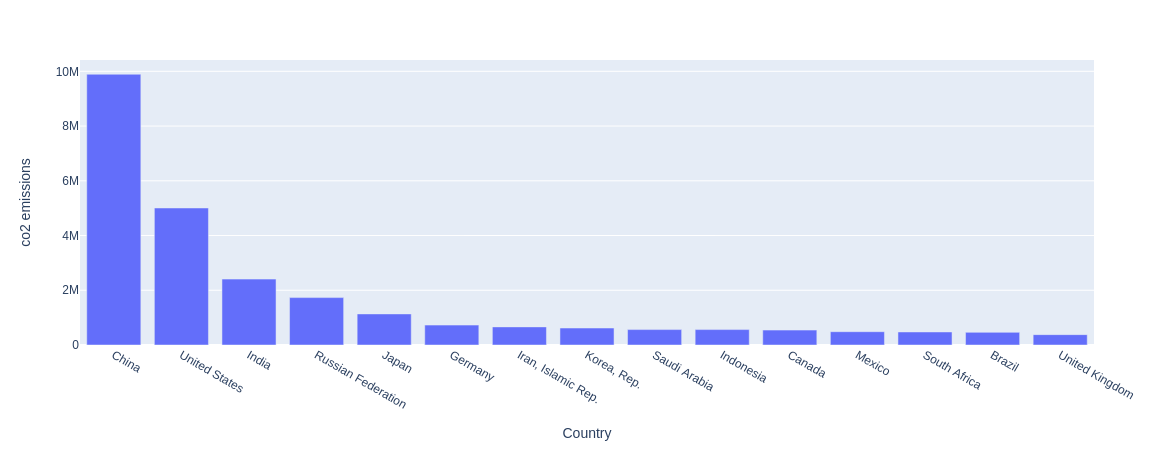

In [47]:
px.bar(
    data_frame=time_series_df[time_series_df.Year == 2016].sort_values(
        by="co2 emissions", ascending=False
    )[:15],
    x="Country",
    y="co2 emissions",
)

## Which countries emitted the most CO2 in total?

Let's visualize emissions throughout history:

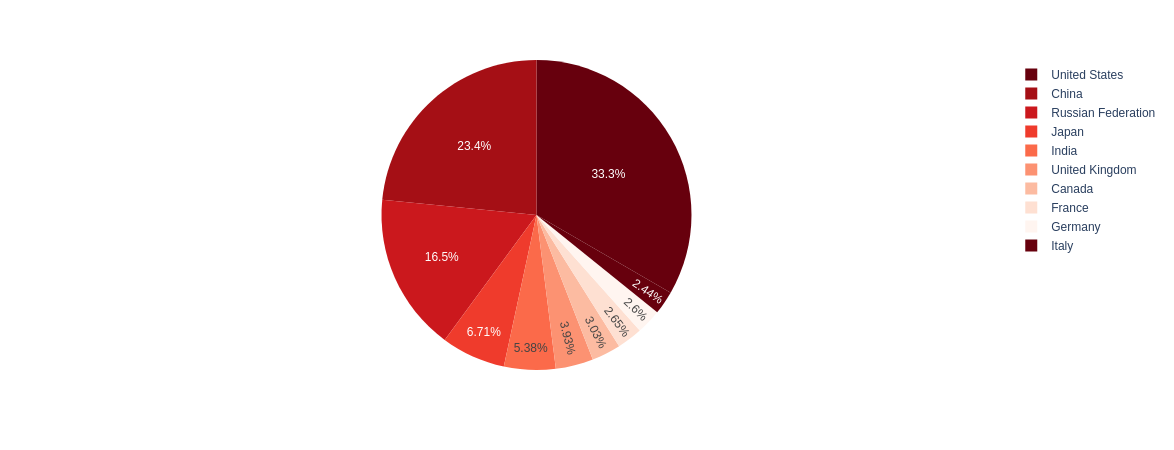

In [39]:
fig = px.pie(
    data_frame=overall_stats_df.loc[
        lambda x: x["Country"].isin(get_top_n_countries(10, "co2 emissions"))
    ],
    names="Country",
    values="co2 emissions",
    color="Country",
    color_discrete_sequence=px.colors.sequential.Reds_r,
)
fig.show()

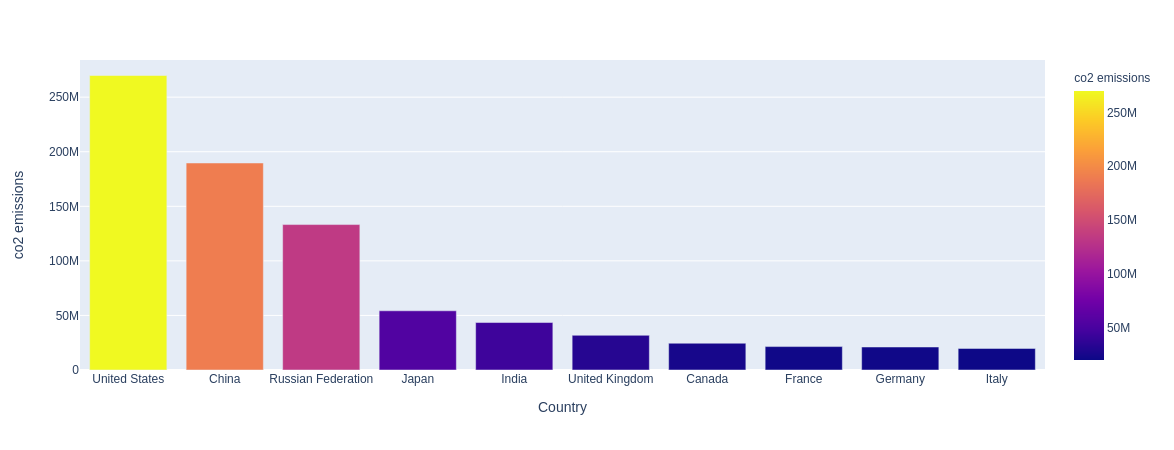

In [40]:
px.bar(
    data_frame=overall_stats_df.loc[
        lambda x: x["Country"].isin(get_top_n_countries(10, "co2 emissions"))
    ],
    x="Country",
    y="co2 emissions",
    color="co2 emissions",
)

## Treemap chart:

In [41]:
# TODO: add treemap chart

## Emissions per capita:

If a country has more people in genral, then its emissions will be of course higher.

In [42]:
overall_stats_df.head()

,Country,co2 emissions,land area,population size,region,incomeLevel,emissions per area,emissions per capita
12,United States,2.698478e+08,9147420.0,3.282395e+08,North America,High income,29.499881,0.822106
17,China,1.896789e+08,9388210.0,1.397715e+09,East Asia & Pacific,Upper middle income,20.203943,0.135706
20,Russian Federation,1.332526e+08,16376870.0,1.443735e+08,Europe & Central Asia,Upper middle income,8.136636,0.922971
25,Japan,5.425695e+07,364560.0,1.262649e+08,East Asia & Pacific,High income,148.828579,0.429707
31,India,4.349570e+07,2973190.0,1.366418e+09,South Asia,Lower middle income,14.629305,0.031832


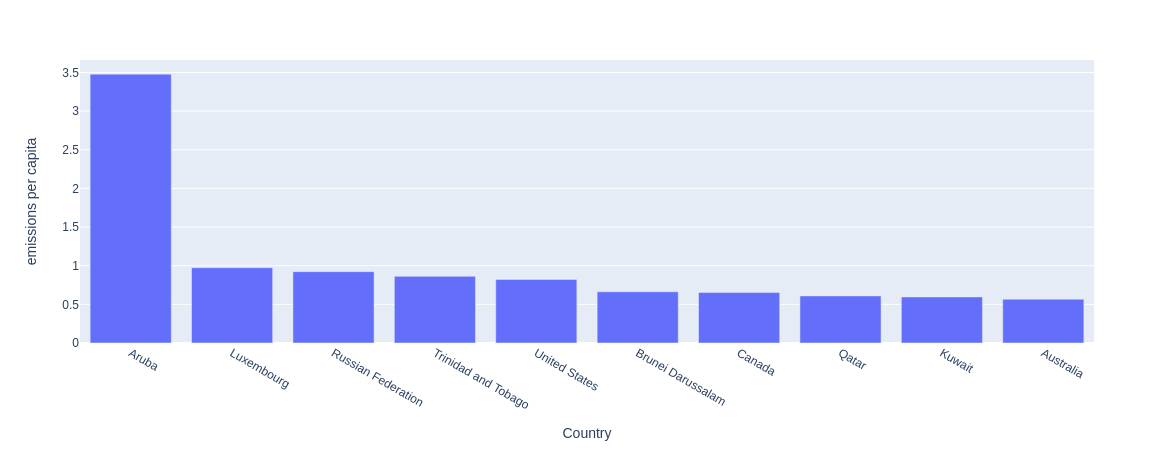

In [43]:
px.bar(
    data_frame=overall_stats_df.loc[
        lambda x: x["Country"].isin(
            get_top_n_countries(n=10, by="emissions per capita")
        )
    ].sort_values(by="emissions per capita", ascending=False),
    x="Country",
    y="emissions per capita",
)

## Emissions per country area:

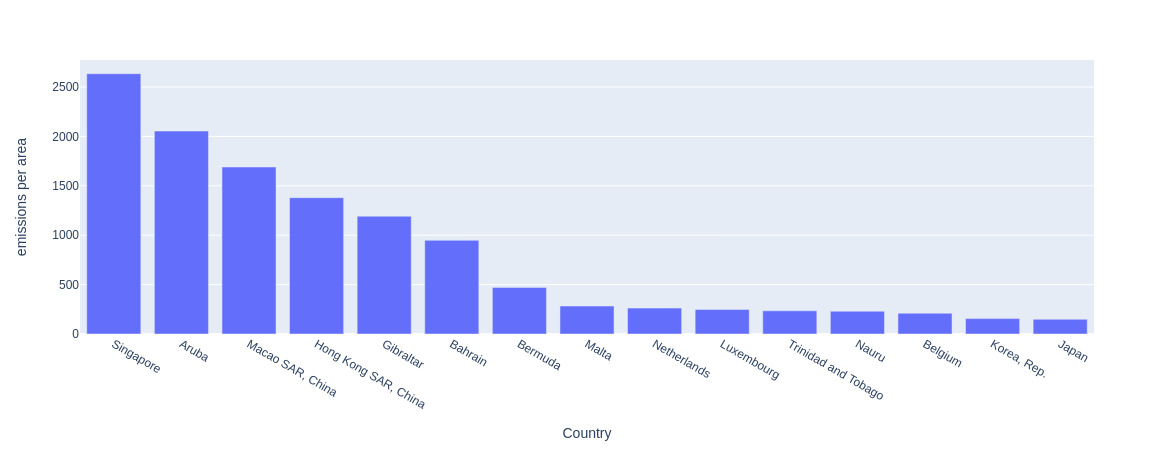

In [44]:
px.bar(
    data_frame=overall_stats_df.loc[
        lambda x: x["Country"].isin(get_top_n_countries(n=15, by="emissions per area"))
    ].sort_values(by="emissions per area", ascending=False),
    x="Country",
    y="emissions per area",
)

## How CO2 emissions increased by country

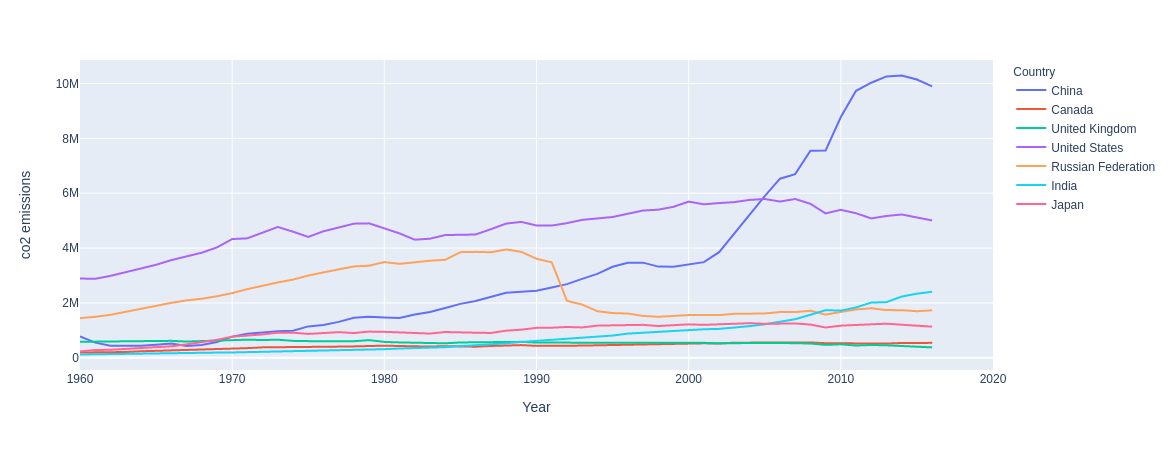

In [45]:
px.line(
    data_frame=time_series_df.loc[
        lambda x: x["Country"].isin(get_top_n_countries(n=7, by="co2 emissions"))
    ],
    x="Year",
    y="co2 emissions",
    line_group="Country",
    color="Country",
)

## How is CO2 emissions related with GDP and poverty:

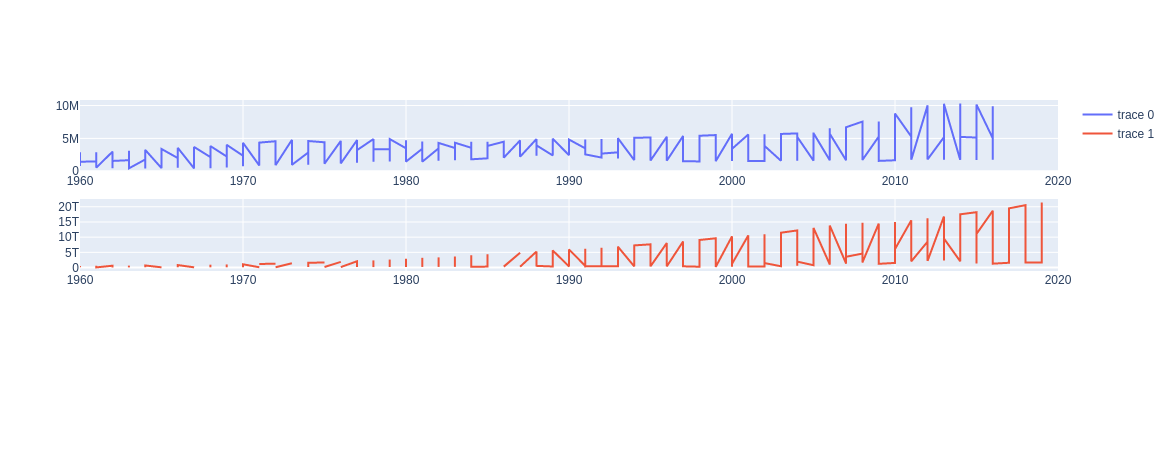

In [46]:
fig = make_subplots(rows=3, cols=1)


temp_df = data_frame = time_series_df.loc[
    lambda x: x["Country"].isin(get_top_n_countries(n=3, by="co2 emissions"))
]

fig.add_trace(go.Scatter(x=temp_df["Year"], y=temp_df["co2 emissions"]), row=1, col=1)

# fig.add_trace(go.Scatter(x=[1, 2, 3], y=[10, 20, 30]), row=2, col=1)
fig.add_trace(go.Scatter(x=temp_df["Year"], y=temp_df["GDP"]), row=2, col=1)

fig.show()